# HMAC (Hash Message Authentication Code)

Vlastnosti hashovacích algoritmů je možné využít k vytvoření jednoduchého elektronického podpisu. Pozor! Tento elektronický podpis je symetrický, tj. kdokoliv ho dokáže ověřit, dokáže ho i padělat. Proto ho typicky používáme v případech, kdy posíláme data sami sobě prostřednictvím nedůvěryhodného kanálu. Např. roundtripování dat přes webového klienta (cookies, URL, pole formuláře).

## Princip HMAC

Základní princip je jednoduchý: k podepisovaným datům přidáme tajný klíč a společně to zahashujeme:

In [1]:
using System.Security.Cryptography;

public string GetSignature(string s, string key) {
    var signedString = s + key;
    var md5 = MD5.Create();
    var hash = md5.ComputeHash(System.Text.Encoding.UTF8.GetBytes(signedString));
    return string.Join(string.Empty, hash.Select(b => b.ToString("x2")));
}

Console.WriteLine($"SIG(HelloWorld): {GetSignature("HelloWorld", "SecretKey")}");
Console.WriteLine($"SIG(HelloWorle): {GetSignature("HelloWorle", "SecretKey")}");

SIG(HelloWorld): b325cf081cf4c8d0471a22ecce830372
SIG(HelloWorle): b87216f8612af161ee45c3a45ef32b9e


**Pozor! výše uvedený kód je nebezpečný, nepoužívejte ho!**

* Používá algoritmus MD5, který není pro tento účel nadále bezpečný. Použil jsem ho jenom protože výsledek je krátký a rozdíl snadno viditelný.
* Spojení zprávy a klíče se ve skutečnosti dělá poněkud sofistikovaněji, aby se zabránilo některým útokům.

## Opravdový HMAC

Je definován v [RFC2104](https://www.rfc-editor.org/rfc/rfc2104.html) a funguje principiálně takto:

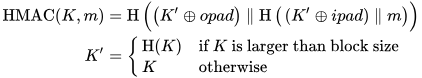

Kde:

* **H** je hashovací funkce
* ***m*** je zpráva
* ***K*** je tajný klíč
* ***opad*** je vnější padding, doplnění dat na velikost bloku pomocí `0x5C`
* ***ipad*** je vnitřní padding, doplnění dat na velikost bloku pomocí `0x36`
* Operace **∥** je zřetězení
* Operace **⊕** je bitová nonekvivalence (XOR)

### HMAC v .NETu

HMAC algoritmy jsou dostupné v .NETu v namespace `System.Security.Cryptography` a jsou odvozené od bázové třídy `HMAC`, např. `HMACSHA256`.

In [2]:
static string GetHmacSignature(string s, string key) {
    var sBytes = System.Text.Encoding.UTF8.GetBytes(s);
    var keyBytes = System.Text.Encoding.UTF8.GetBytes(key);

    var hmac = new HMACSHA256(keyBytes);
    var hash = hmac.ComputeHash(sBytes);
    
    return string.Join(string.Empty, hash.Select(b => b.ToString("x2")));
}

Console.WriteLine($"HMACSHA256(HelloWorld): {GetHmacSignature("HelloWorld", "SecretKey")}");
Console.WriteLine($"HMACSHA256(HelloWorlc): {GetHmacSignature("HelloWorlc", "SecretKey")}");

HMACSHA256(HelloWorld): 75c63d7355ccd5daa1a34558788efc79d1897bcdf75d5592f183682f3d8aacc3
HMACSHA256(HelloWorlc): 250fea3e4b7f00f0af8fb840defe3f191b9bb080a0fc6e096376009f9a177503


## Použití HMAC

ASP.NET používá HMAC prakticky všude, kde se nějaká data posílají přes klienta (browser), např.:

* ViewState, ControlState (v .NET Frameworku).
* Autentizační tokeny v cookie.
* CSRF token jako skryté pole formuláře.

Můžete ho používat i vy:

* Podepisování jiných cookies.
* Podepisování URL, aby nemohla být modifikována, např. při autentizaci API. V takovém případě ale pozor na replay attacky, data by měla obsahovat počítadlo nebo aktuální čas.